In [1]:
'''
Author: Salah Eddine Feddaoui Dellalou
Date: 23-04-2025
Description: This file is the benchmark notebook for Xsuite and mbtrack2 tracking codes
Date de dernière modification: 23-04-2025
'''

'\nAuthor: Salah Eddine Feddaoui Dellalou\nDate: 23-04-2025\nDescription: This file is the benchmark notebook for Xsuite and mbtrack2 tracking codes\nDate de dernière modification: 23-04-2025\n'

## Context:

In this notebook I will showcase how the different codes work in order to simulate intrabeam scattering for the synchrotrons, we will treat the electron booster FCC-ee, since at high energy the instrabeam scattering inside an electron beam is not negligable and should be evaluated.

## Purpos
- This code generate an agreement between Xsuite and Mbtrack using only Synchrotron radiation and no scattering, unmatched bunch imported from xsuite to mbtrack


In [1]:
import json, sys, os, warnings, random, string, shutil, pandas, pickle
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import h5py
import time
import scipy.constants as cons
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from tqdm.notebook import trange
import xtrack as xt
import xpart as xp
import xfields as xf
import xobjects as xo
import xcoll as xc
import xwakes as xw

In [2]:
from mbtrack2 import Synchrotron, Electron
from mbtrack2.utilities import Optics
from mbtrack2.impedance.wakefield import WakeField
from mbtrack2.tracking import LongitudinalMap, SynchrotronRadiation, TransverseMap
from mbtrack2.tracking import IntrabeamScattering
from mbtrack2.tracking import Beam, Bunch, WakePotential
from mbtrack2.tracking import RFCavity, SynchrotronRadiation
from mbtrack2.tracking.monitors import BunchMonitor, WakePotentialMonitor
from mbtrack2.tracking.feedback import FIRDamper, ExponentialDamper
import at

mbtrack2 version 0.8.0
(dirty git work tree)
--------------------------------------------------
If used in a publication, please cite mbtrack2 paper and the zenodo archive for the corresponding code version (and other papers for more specific features).
[1] A. Gamelin, W. Foosang, N. Yamamoto, V. Gubaidulin and R. Nagaoka, “mbtrack2”. Zenodo, Dec. 16, 2024. doi: 10.5281/zenodo.14418989.
[2] A. Gamelin, W. Foosang, and R. Nagaoka, “mbtrack2, a Collective Effect Library in Python”, presented at the 12th Int. Particle Accelerator Conf. (IPAC'21), Campinas, Brazil, May 2021, paper MOPAB070.




## Loading parameters:

We start by loading the parameters and making the necessary unit conversion for both codes.

In [3]:
class beam_param:
    """
    Class to define the beam parameters from input file
    """
    def __init__(self, mode, **kw):
        if mode == None:
            print('No mode entered -> default = z')
            mode = 'z'
        self.filename()
        self.read_param(mode)
        self.set_param()

    def filename(self):
        # parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
        input_dir = "_inputs/" #parent_dir + '/_inputs/'
        self.filename = input_dir + 'Booster_parameter_table.json'
        
    def read_param(self, mode):
        inputs_tab = json.load(open(self.filename))
        # print(inputs_tab.keys())

        # define variables
        self.C = inputs_tab['C']['value'] # circumference [m]
        self.Np = inputs_tab['Np'][mode] # number of particles per bunch
        self.Nb = inputs_tab['Nb'][mode] # number of bunches
        self.Etot = inputs_tab['E']['injection'] # energy at injection [eV]
        self.epsnx = inputs_tab['bunch']['epsnx']['value'] # normalised horizontal emittance [m]
        self.epsny = inputs_tab['bunch']['epsny']['value'] # normalised horizontal emittance [m]
        self.sigmaz = inputs_tab['bunch']['sigmaz']['value'] # bunch length at injection [m]
        self.sigmae = inputs_tab['bunch']['sigmae']['value'] # energy spread at injection
        self.Qx = inputs_tab['optics']['Qx'][mode] # horizontal tune
        self.Qy = inputs_tab['optics']['Qy'][mode] # vertical tune
        self.chix = inputs_tab['optics']['chix'][mode] # horizontal chromaticity
        self.chiy = inputs_tab['optics']['chiy'][mode] # horizontal chromaticity
        self.alpha = inputs_tab['optics']['alpha'][mode] # momentum compaction
        self.I2 = inputs_tab['optics']['I2'][mode] # 2nd synchrotron integral
        self.I3 = inputs_tab['optics']['I3'][mode] # 3rd synchrotron integral
        self.I5 = inputs_tab['optics']['I5'][mode] # 5th synchrotron integral
        self.I6 = 0 # 6th synchrotron integral
        self.dpt = inputs_tab['optics']['dpt'][mode] # maximum energy acceptance at injection
        self.damp_xy = inputs_tab['optics']['damp_xy'][mode] # transverse damping time at injection energy
        self.damp_s = inputs_tab['optics']['damp_s'][mode] # longitudinal damping time at injection energy
        self.coupling = inputs_tab['optics']['coupling'][mode] # horizontal vertical coupling
        self.Cq = 3.8319e-13
        self.Cgamma = 8.846e-05
        self.Erest = 510998.9499961642 # rest energy [eV]
        self.Egain = 0 # energy gain [eV]
        self.freq = inputs_tab['RF']['RF_freq'][mode] # RF frequency [Hz]
        self.Vtot = inputs_tab['RF']['Vtot'][mode] # total cavities voltage [eV]
        self.Qs = inputs_tab['RF']['Qs_inj'][mode] # synchronous tune at injection
        self.phi_s = inputs_tab['RF']['phis_inj'][mode] # synchronous phase at injection
        
    def set_param(self):
        self.lambdaRF = cons.c/self.freq # RF wavelength
        self.frev = cons.c/self.C # revolution frequency
        self.h = self.freq/self.frev # Schottky number
        self.U0 = self.Cgamma*(self.Etot*1e-9)**4/2/np.pi*self.I2*1e9 # Synchrotron energy loss per turn
        self.gamma = self.Etot / self.Erest
        self.sig_e_eq = np.sqrt(self.Cq*self.gamma**2*self.I3/(2*self.I2))#*(self.Etot*1e-9)**2)
        self.emit_eq = self.Cq * self.gamma**2 * self.I5 / self.I2 # geometrical equilibrium emittance
        self.epsnx_eq = self.emit_eq * self.gamma # normalized equilibrium emittance X
        self.epsny_eq = self.epsnx_eq * 2e-3 # normalized equilibrium emittance Y
        self.eta = 1/self.gamma**2-self.alpha # momentum compaction
#Loading the beam parameters into an object
beam_param = beam_param(mode=None)

No mode entered -> default = z


## Setting defaults
- This cell sets the default parameters, such as number of turns and number of macroparticles, as well as Time that will be used to name the file, both outputs will be named with the same reference date and time with slightly different comment.

In [5]:
temps = time.strftime("%y%m%d_%H%M%S", time.localtime())
comment = "_ibs_dx_0_unmatched_xbunch_2e9Np"
n_macroparticles = 100_0
n_turns = 70_000
modelname = 'CIMP'
input_dir = '_inputs/'
output_dir = '_outputs/'
optics_file = input_dir + 'heb_ring_withcav.json' # optics file
lattice =  input_dir + 'V24_1FODO_02.mat'
mass =xp.ELECTRON_MASS_EV # mass of the particle
q0 = -1 # charge of the particle
mbtrack2_output = output_dir + modelname+"_jupyter_"+temps+comment
chunk_size = 10
n_chunk = int(np.ceil(n_turns/chunk_size))
ibs_slicing = 10
beam_param.Np = 2.5e5
# beam_param.damp_xy = 8.940073794
# beam_param.damp_s = 4.470036897
# beam_param.U0 = 1.360723085e6
# beam_param.Vtot = 62e6
# beam_param.sigmae = 0.0033
# beam_param.sigmaz = 0.0012
# beam_param.gamma = 39139.02368

## Setting Line
- Setting the line from which we will take the twiss parameters to build the map for both codes.

In [6]:
# twiss parameters for xsuite
context = xo.ContextCpu(omp_num_threads="auto")

line = xt.Line.from_json(optics_file)
particle_ref = xp.Particles(mass0=mass, q0=q0, gamma0=beam_param.gamma)
line.particle_ref = particle_ref

line.slice_thick_elements( slicing_strategies=[
xt.Strategy(slicing=xt.Teapot(2)), 
xt.Strategy(slicing=xt.Teapot(3), element_type=xt.Bend), 
xt.Strategy(slicing=xt.Teapot(5), element_type=xt.Quadrupole), 
xt.Strategy(slicing=xt.Teapot(3), element_type=xt.Sextupole)])
line.build_tracker()
line.configure_radiation(model='mean')
environment = line.env
tw = line.twiss(method="6d" ,eneloss_and_damping=True)
C =  tw.s[-1] # circumference
qx =  tw.qx # horizontal tune
qy =  tw.qy # vertical tune
dqx =  tw.dqx # horizontal chromaticity
dqy =  tw.dqy # vertical chromaticity
eneloss_turn = tw.eneloss_turn
df = tw.to_pandas()
betax_0 = beam_param.C / (2*np.pi*tw.qx) # should be tweaked
# betax_0 = 54.4
df["distance"] = abs(df.betx - betax_0)
smallest = df.nsmallest(10, 'distance')
smallest = smallest.drop('distance', axis=1)
index = smallest.dx.idxmin()
alphax = smallest.alfx[index] 
alphay = smallest.alfy[index] 
dx = smallest.dx[index] 
dy = smallest.dy[index]
betax = smallest.betx[index]
betay = smallest.bety[index]
dpx = smallest.dpx[index]
dpy = smallest.dpy[index]

Loading line from dict:   0%|          | 0/34804 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/34804 [00:00<?, ?it/s]

## Building the map
- We define the noise parameters that will give us the synchrotron damping, and we give them to the map function.

In [7]:
dx = 0.0
dpx = 0.0
dy = 0.0
dpy = 0.0

In [8]:
det_= line.get_amplitude_detuning_coefficients(
    nemitt_x=beam_param.epsnx, 
    nemitt_y=beam_param.epsny, 
    num_turns=500, 
    a0_sigmas=0.01, 
    a1_sigmas=0.1, 
    a2_sigmas=0.2
)
damping_rate_emit_h = 2 * tw.damping_constants_turns[0] # horizontal damping rate
damping_rate_emit_v = 2 * tw.damping_constants_turns[1] # horizontal damping rate
damping_rate_emit_zeta = 2 * tw.damping_constants_turns[2] # longitudinal damping rate

N = len(tw.betx)
rand = np.random.standard_normal(size=N)
rand = abs(rand)

gauss_noise_ampl_px = 2 * np.sqrt(tw.eq_gemitt_x * (np.pi/2) * damping_rate_emit_h / betax)
gauss_noise_ampl_x = 0
gauss_noise_ampl_py = 2 * np.sqrt(tw.eq_gemitt_y * (np.pi/2) * damping_rate_emit_h / betay)
gauss_noise_ampl_y = 0
gauss_noise_ampl_delta = 2 * np.sqrt(tw.eq_gemitt_zeta * (np.pi/2) *  damping_rate_emit_zeta / tw.bets0)
T = beam_param.damp_xy *cons.c / beam_param.C
tau = 2 / T

gauss_noise_ampl_delta = np.average(gauss_noise_ampl_delta)
gauss_noise_ampl_x = np.average(gauss_noise_ampl_x)
gauss_noise_ampl_px = np.average(gauss_noise_ampl_px)
gauss_noise_ampl_y = np.average(gauss_noise_ampl_y)
gauss_noise_ampl_py = np.average(gauss_noise_ampl_py)

det_xx = det_['det_xx']
det_yy = det_['det_yy']
det_xy = det_['det_xy']
det_yx = det_['det_yx']
map_line =  xt.LineSegmentMap(
                    length=beam_param.C,
                    qx=beam_param.Qx,
                    qy=beam_param.Qy,
                    dqx=tw.dqx,
                    dqy=tw.dqy,
                    momentum_compaction_factor=beam_param.alpha,
                    betx=betax,
                    bety=betay,
                    alfx=alphax,
                    alfy=alphay,
                    dx = dx,
                    dpx = dpx,
                    dpy = dpy,
                    dy = dy,
                    det_xx=det_xx,
                    det_xy=det_xy,
                    det_yx=det_yx,
                    det_yy=det_yy,  
                    damping_rate_x=  damping_rate_emit_h,
                    damping_rate_y=  damping_rate_emit_v,
                    # In longitudinal all damping goes on the momentum
                    damping_rate_zeta=0,
                    damping_rate_pzeta=damping_rate_emit_zeta,
                    gauss_noise_ampl_px=gauss_noise_ampl_px,
                    gauss_noise_ampl_py=gauss_noise_ampl_py,
                    gauss_noise_ampl_pzeta=gauss_noise_ampl_delta,
                    energy_increment           = -1 * tw.eneloss_turn,#M.U0,
                    longitudinal_mode          = 'nonlinear', # needs to be commented for 4D tracking + uncomment betas/qs
                    voltage_rf                 = [beam_param.Vtot], # needs to be commented for 4D tracking + uncomment betas/qs
                    frequency_rf               = [beam_param.freq], # needs to be commented for 4D tracking + uncomment betas/qs
                    lag_rf                     = [180 - np.rad2deg(np.arcsin(tw.eneloss_turn/beam_param.Vtot))], # needs to be commented for 4D tracking + uncomment betas/qs
                )

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


## Building the map for mbtrack2
- Here we build the map for mbtrack2 and we do that by defining the parameters and calling Synchrotron function without loading lattice, we use the same optics parameters that were extracted from Line.

In [9]:
#we define twiss parameters for mbtrack2
def v24(parameter = beam_param, lattice = lattice):
    """
    read lattice .mat format (loaded with AT) and returns ring object
    Takes Parameters from beam_param class

    Returns
    -------
    ring : Synchrotron object

    """    
    load_lattice = False 
    ####################
    h = parameter.Nb
    particle = Electron()
    tau =   np.array([parameter.damp_xy, parameter.damp_xy, parameter.damp_s]) #np.array([11.49, 11.49, 5])   
    sigma_0 = parameter.sigmaz/cons.c
    sigma_delta = parameter.sigmae
    emit = np.array([parameter.epsnx/parameter.gamma, parameter.epsny/parameter.gamma])
    f0 = parameter.freq
    f1 = parameter.frev
    U0 = parameter.U0
    ac = parameter.alpha
    lattice_file = lattice
    chro = np.array([parameter.chix, parameter.chiy])
    gamma = parameter.gamma
    tune = np.array([parameter.Qx, parameter.Qy])
    local_alpha = np.array([alphax,alphay])#np.array([np.average(tw.alfx), np.average(tw.alfy)])
    local_beta = np.array([betax, betay])#np.array([np.average(tw.betx), np.average(tw.bety)])
    local_disp = np.array([dx,dpx,dy,dpy])
    L = beam_param.C
    E0=beam_param.Etot

    if load_lattice == True:
        optics = Optics(lattice_file=lattice_file, n_points=1e4)
        ring = Synchrotron(h, optics, particle, tau=tau,emit=emit, 
                   sigma_0=sigma_0, sigma_delta=sigma_delta, f0=f0, f1=f1, U0=U0, ac=ac, chro=chro, gamma=gamma, tune=tune)
    else:
        optics = Optics(local_alpha=local_alpha,local_beta=local_beta,local_dispersion=local_disp, n_points=1e4)
        ring = Synchrotron(h, optics, particle, tau=tau,emit=emit, 
                   sigma_0=sigma_0, sigma_delta=sigma_delta, f0=f0, f1=f1, U0=U0, ac=ac, chro=chro, gamma=gamma, L=L, E0=E0,tune=tune)

    
    return ring

ring = v24()

In [10]:
#associating  the map to  the line
ring_map_no_excit = map_line.copy()
environment.elements['ring_map'] = map_line
ring_map_no_excit.gauss_noise_matrix = 0
ring_map = xt.Line(elements=[ring_map_no_excit])
ring_map._needs_rng = True
ring_map.particle_ref = particle_ref.copy()
tw_check = ring_map.twiss()
ring_map.correct_trajectory(twiss_table=ring_map.twiss4d())

## Generating the bunch for mbtrack2

In [11]:
# Generating bunch for mbtrack2
bunch_current = beam_param.Np * cons.elementary_charge * cons.c / beam_param.C 
particle = Electron()

mybunch = Bunch(
    ring, mp_number=n_macroparticles, current=bunch_current, track_alive=True)
np.random.seed(42)
rng = np.random.RandomState(42)
mybunch.init_gaussian()

## Generating the bunch for Xsuite
- There are two methods, matched and unmatched, comment the one you don't need

In [12]:
# Generating bunch for xsuite

#############################################
x_norm = rng.randn(n_macroparticles)
px_norm = rng.randn(n_macroparticles)
y_norm = rng.randn(n_macroparticles)
py_norm = rng.randn(n_macroparticles)
zeta = beam_param.sigmaz * (rng.randn(n_macroparticles))
delta = beam_param.sigmae * (rng.randn(n_macroparticles))
################################################

#################### Matched Bunch ############################
# particles = xp.generate_matched_gaussian_bunch(
#                 num_particles=n_macroparticles,
#                 nemitt_x=beam_param.epsnx,
#                 nemitt_y=beam_param.epsny,
#                 sigma_z=beam_param.sigmaz,
#                 total_intensity_particles=beam_param.Np,
#                 line=line, _context = context)

################### Unmatched Bunch ##############################
particles = ring_map.build_particles(
    _context=context, 
    _buffer=None, 
    _offset=None,
    particle_ref=particle_ref,
    zeta=zeta, 
    delta=delta,
    x_norm=x_norm, 
    px_norm=px_norm,
    y_norm=y_norm, 
    py_norm=py_norm,
    nemitt_x=beam_param.epsnx, 
    nemitt_y=beam_param.epsny,

    weight=beam_param.Np/n_macroparticles)

- in this cell we import Xsuite bunch into mbtrack2 this will assure that we are starting from the same initial conditions using the same bunch

In [13]:
mybunch["x"] = particles.x
mybunch["xp"] = particles.px
mybunch["y"] = particles.y
mybunch["yp"] = particles.py
mybunch["tau"]= particles.zeta/cons.c
mybunch["delta"] = particles.delta

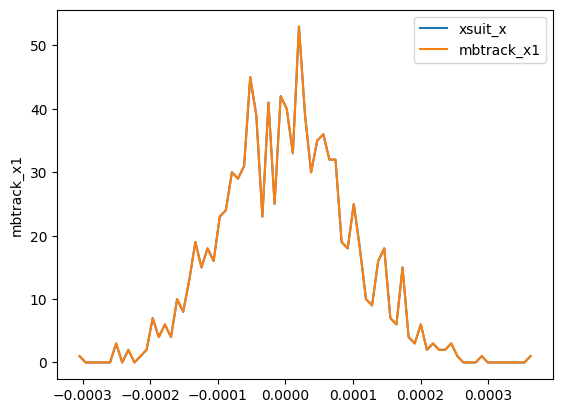

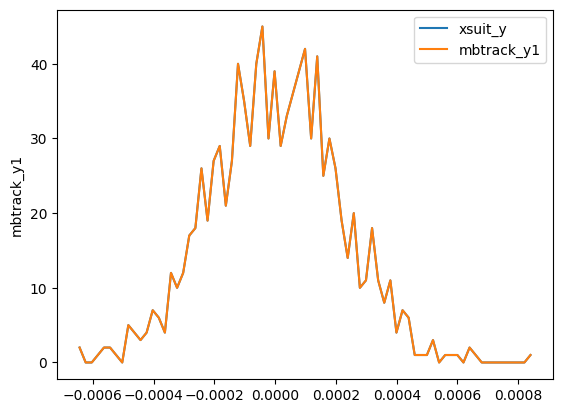

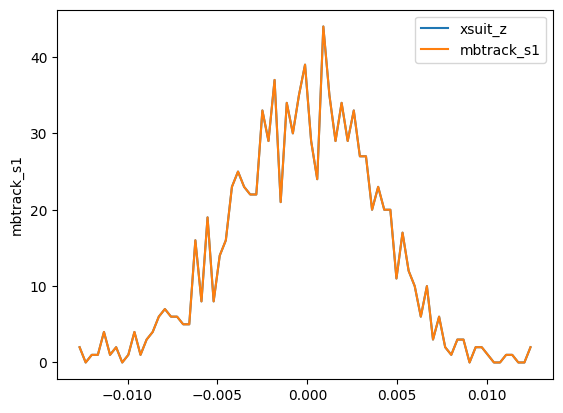

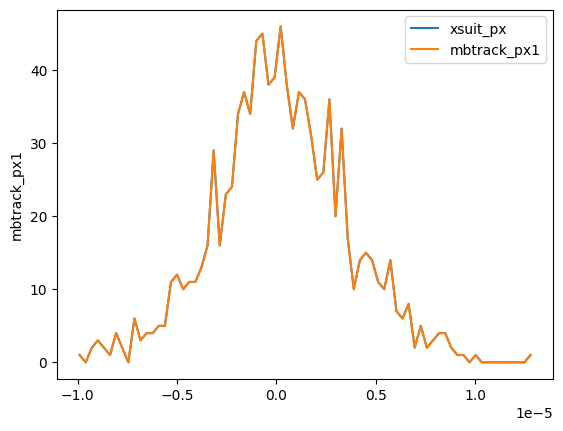

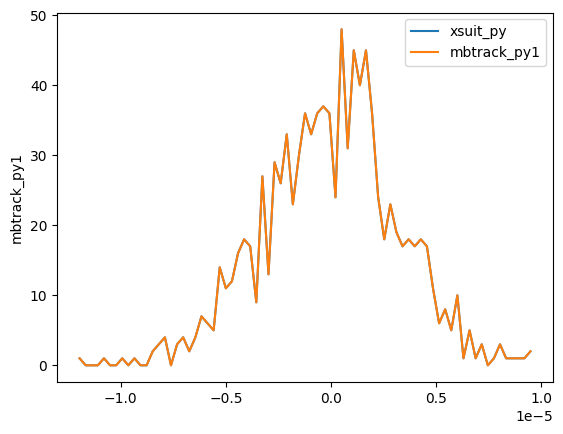

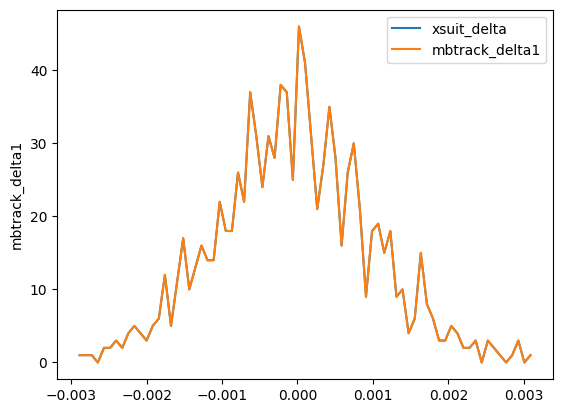

In [14]:
%matplotlib inline
n_bin = 75

x = np.array(particles.x)
px = np.array(particles.px)
y = np.array(particles.y)
py = np.array(particles.py)
z = np.array(particles.zeta)
delta = np.array(particles.delta)


x1 = np.array(mybunch["x"])
xp1 = np.array(mybunch["xp"])
y1 = np.array(mybunch["y"])
yp1 = np.array(mybunch["yp"])
s1 = np.array(mybunch["tau"])
s1 = s1*cons.c
delta1 = np.array(mybunch["delta"])


dimensions = [x,y,z,x1,y1,s1]
dims = {"xsuit_x":x, "mbtrack_x1":x1, "xsuit_y":y, "mbtrack_y1":y1, "xsuit_z":z, "mbtrack_s1":s1, "xsuit_px":px, "mbtrack_px1":xp1, "xsuit_py":py, "mbtrack_py1":yp1, "xsuit_delta":delta, "mbtrack_delta1":delta1 }
i = 0
for el, val in dims.items():
    bin_min = val.min()
    bin_min = min(bin_min * 0.99, bin_min * 1.01)
    bin_max = val.max()
    bin_max = max(bin_max * 0.99, bin_max * 1.01)
    bins = np.linspace(bin_min, bin_max, n_bin + 1)
    center = (bins[1:] + bins[:-1]) / 2
    sorted_index = np.searchsorted(bins, val, side="left")
    sorted_index -= 1
    profile = np.bincount(sorted_index, minlength=n_bin)
    plt.plot(center, profile, label=str(el))
    plt.ylabel(el)
    plt.legend()
    i+=1
    if i == 2 :
        plt.show()
        i = 0
 


- Setting synchrotron radiation tracker for mbtrack2

In [15]:
# Synchrotron radiation mbtrack2
sr = SynchrotronRadiation(ring, switch=[1, 1, 1])

- Setting Cavity tracker for mbtrack2
- Setting the equilibrium emittance and equilibrium spread, since mbtrack takes those parameters once and use them to create a bunch, that usually gives us an oscillation around the initial value making seeing the damping not possible, this approach provides such results.

In [16]:
# Setting Cavity for mbtrack2
ring.emit = np.array([beam_param.epsnx_eq / beam_param.gamma, beam_param.epsny_eq / beam_param.gamma]) * 2
ring.sigma_delta = beam_param.sig_e_eq
ring.emit[1] = 0.002*ring.emit[0]

V_rf  = beam_param.Vtot
theta = -1*  np.pi * beam_param.phi_s / 180
# theta = -1*np.arccos(beam_param.U0/beam_param.Vtot)
theta_in_cc2 = np.arccos(eneloss_turn/V_rf)

rf = RFCavity(ring, m=1, Vc=V_rf, theta=theta_in_cc2)

## Setting IBS for mbtrack2
- We set the IBS tracker object for mbtrack2 such as optics parameters take the same values given by Line

In [17]:
# Setting ibs for mbtrack2
ibs = IntrabeamScattering(ring,model=modelname, n_points=1000, n_bin=ibs_slicing)    
ibs.dispX = dx # tw.dx
ibs.dispY = dpx #tw.dy
ibs.disppX = dy #tw.dpx
ibs.disppY = dpy #tw.dpy
ibs.beta_x = betax # tw.betx
ibs.beta_y = betay #tw.bety
ibs.alphaX = alphax # tw.alfx
ibs.alphaY = alphay # tw.alfy

## Setting IBS for Xsuite
- In this cell we configure IBS for xsuite taking into accound the same partition (bin size) such as we have the same macroparticles density

In [18]:
ibs_kick = xf.IBSAnalyticalKick(formalism="B&M", num_slices=ibs_slicing)
# ibs_kick = xf.IBSKineticKick(num_slices=50)
line.configure_intrabeam_scattering(element=ibs_kick,index=-1, name="ibskick", update_every=1)

environment.elements["ring_map"] = map_line
line_map = environment.new_line(name="line_map", components=["ring_map", "ibskick"])

line_map.particle_ref = particle_ref.copy()
line_map._needs_rng = True
line_map.build_tracker()
line_map.configure_radiation(model='quantum')

The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


## Growth rate
- In this cell we can check and compare the growth rates and growth coefficients before tracking, since tracking with IBS takes longer than tracking with Synchrotron radiation only, this also allows us to check with other codes like Mad-x, the computed growth rates and times with different models.

In [19]:
ibs.initialize(mybunch)
a, b = ibs.scatter()
R_x, R_y, R_s = ibs.get_scatter_T(g_ab=a, g_ba=b)
# a,b,c = ibs.scatter()
# R_x, R_y, R_s = ibs.get_scatter_T(vabq=a, v1aq=b, v1bq=c)



bm_growth_rates = tw.get_ibs_growth_rates(
    formalism="bjorken-mtingwa",  # also accepts "b&m"
    total_beam_intensity=beam_param.Np,
    nemitt_x=beam_param.epsnx,
    nemitt_y=beam_param.epsny,
    sigma_delta=beam_param.sigmae,
    bunch_length=beam_param.sigmaz,)

na_growth_rates = tw.get_ibs_growth_rates(
    formalism="nagaitsev",  # also accepts "b&m"
    total_beam_intensity=beam_param.Np,
    nemitt_x=beam_param.epsnx,
    nemitt_y=beam_param.epsny,
    sigma_delta=beam_param.sigmae,
    bunch_length=beam_param.sigmaz,)

bm_emit_rates = bm_growth_rates.to_emittance_growth_rates()
bm_emmit_times = bm_growth_rates.to_emittance_growth_times()
Dpx, Dpy, Dpz = ibs.kick(mybunch, T_x=R_x, T_y=R_y, T_p=R_s)
print(f"mbtrack growth rates: Delta_px={np.average(Dpx)}, Delta_py={np.average(Dpy)}, Delta_pz={np.average(Dpz)}")
print(50*"-")
print(f"Bjorken-Mtingwa Emit rates: {bm_emit_rates}")
print(f"Bjorken-Mtingwa Emit times: {bm_emmit_times}")
print(50*"-")

print(f"Nagaitsev:       {na_growth_rates}")
print(f"Bjorken-Mtingwa: {bm_growth_rates}")
print(50*"-")
print("-------",xf.IBSAnalyticalKick.compute_kick_coefficients(ibs_kick,particles))
print(f"scattering rates mbtrack2: Tx={R_x}, Ty={R_y}, Ts={R_s}")

Vertical dispersion is present, Nagaitsev formalism does not account for it


mbtrack growth rates: Delta_px=0.0, Delta_py=0.0, Delta_pz=-1.4780463945486534e-10
--------------------------------------------------
Bjorken-Mtingwa Emit rates: IBSEmittanceGrowthRates(Kx=1.58e-07, Ky=-7.88e-12, Kz=1.66e-07)
Bjorken-Mtingwa Emit times: (6319160.90530474, -126892342288.46797, 6041481.770910284)
--------------------------------------------------
Nagaitsev:       IBSAmplitudeGrowthRates(Kx=7.93e-08, Ky=-3.93e-12, Kz=8.25e-08)
Bjorken-Mtingwa: IBSAmplitudeGrowthRates(Kx=7.91e-08, Ky=-3.94e-12, Kz=8.28e-08)
--------------------------------------------------
------- IBSKickCoefficients(Kx=6.67e-12, Ky=0, Kz=7.98e-10)
scattering rates mbtrack2: Tx=0, Ty=0, Ts=9.18231203811565e-08


- Setting mbtrack2 monitor

In [22]:
# Setting monitor for mbtrack2
monitor_mbtrack = BunchMonitor(1, 1,buffer_size=10, total_size=n_turns, file_name=mbtrack2_output)

- Setting Xsuite monitor

In [23]:
# Setting Monitor for xsuite
emit_mon = xc.EmittanceMonitor.install(line=line_map, name="EmittanceMonitor", at=0, stop_at_turn=n_turns)

- Setting line map trackers

In [24]:
# Setting line for mbtrack2
long_map = LongitudinalMap(ring)
trans_map = TransverseMap(ring)

In [25]:
#Tracking using mbtrack2
tracking_elements = [trans_map, long_map, rf, sr,ibs]
for i in trange(n_turns):      
    for el in tracking_elements:
        el.track(mybunch)
    monitor_mbtrack.track(mybunch)

  0%|          | 0/70000 [00:00<?, ?it/s]

- Tracking using Xsuite and saving data

In [ ]:
#Tracking using Xsuite
mean_x  = []
mean_y  = []
mean_z  = []
mean_e = []
sigma_x = []
sigma_y = []
sigma_z = []
sigma_e = []
for i_chunk in trange(n_chunk):
    monitor = xt.ParticlesMonitor(_context= context,start_at_turn=i_chunk*chunk_size, stop_at_turn=(i_chunk+1)*chunk_size,num_particles=n_macroparticles)   
    line_map.track(particles, num_turns=chunk_size, turn_by_turn_monitor=monitor, with_progress=False)
    mean_x[i_chunk*chunk_size : (i_chunk+1)*chunk_size] = np.average(monitor.x, axis=0)
    mean_y[i_chunk*chunk_size:(i_chunk+1)*chunk_size]   = np.average(monitor.y,axis=0)
    mean_z[i_chunk*chunk_size:(i_chunk+1)*chunk_size]   = np.average(monitor.zeta,axis=0)
    mean_e[i_chunk*chunk_size:(i_chunk+1)*chunk_size]   = np.average(monitor.delta,axis=0)
    sigma_x[i_chunk*chunk_size:(i_chunk+1)*chunk_size]  = np.std(monitor.x,axis=0)
    sigma_y[i_chunk*chunk_size:(i_chunk+1)*chunk_size]  = np.std(monitor.y,axis=0)
    sigma_z[i_chunk*chunk_size:(i_chunk+1)*chunk_size]  = np.std(monitor.zeta,axis=0)
    sigma_e[i_chunk*chunk_size:(i_chunk+1)*chunk_size]  = np.std(monitor.delta,axis=0)
    

  0%|          | 0/7000 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


- Saving Xsuite tracked data into a file

In [ ]:
output = {
    'epsx' : {
        'value' : emit_mon.gemitt_x.tolist(),
        'label' : r'$\epsilon_x$'
    },
    'epsy' : {
        'value': emit_mon.gemitt_y.tolist(),
        'label': r'$\epsilon_y$'
    },
    'epsz' : {
        'value': emit_mon.gemitt_zeta.tolist(),
        'label': r'$\epsilon_z$'
    },
    'meanx' : {
        'value': list(mean_x),
        'label' : r'$\bar{x}$'
    },
    'meany' : {
        'value': list(mean_y),
        'label' : r'$\bar{y}$'
    },
    'meanz' : {
        'value': list(mean_z),
        'label' : r'$\bar{z}$'
    },
    'meane' : {
        'value': list(mean_e),
        'label' : r'$\bar{e}$'
    },
    'sigmax' : {
        'value': list(sigma_x),
        'label' : r'$\sigma_x$'
    },
    'sigmay' : {
        'value': list(sigma_y),
        'label' : r'$\sigma_y$'
    },
    'sigmaz' : {
        'value': list(sigma_z),
        'label' : r'$\sigma_z$'
    },
    'sigmae' : {
        'value' : list(sigma_e),
        'label' : r'$\sigma_e$'
    },
    # 'inputs' : self._inputs,
    'parameters': vars(beam_param),
    # 'comment' : self.comments
}

filename = '_outputs/xsuite_jupyter_'+temps+'_'+comment+'.json'
with open(filename, 'w') as json_file:
    json.dump(output, json_file)
print("Done!")

179.25145657508972


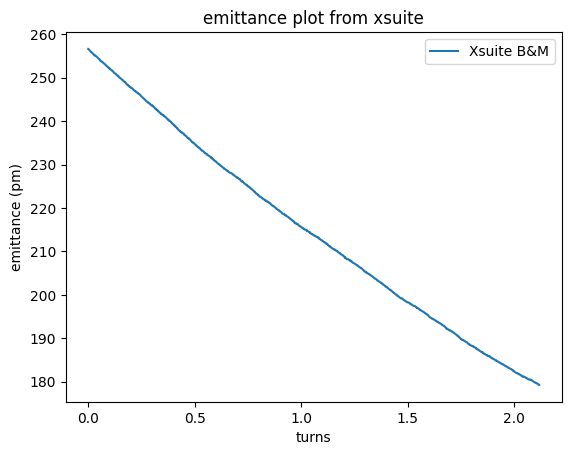

--------------------------------------------------
filename : _inputs/Booster_parameter_table.json
C : 90658.74531999999
Np : 25000000000.0
Nb : 1120
Etot : 20000000000.0
epsnx : 9.999999999999999e-06
epsny : 9.999999999999999e-06
sigmaz : 0.004
sigmae : 0.001
Qx : 414.225
Qy : 410.29
chix : 2.057246532
chiy : 1.778971585
alpha : 7.120435962e-06
I2 : 0.0005936549319
I3 : 5.681453654e-08
I5 : 1.698280783e-11
I6 : 0
dpt : 0.03
damp_xy : 9.045401802006868
damp_s : 4.522700901003434
coupling : 0.002
Cq : 3.8319e-13
Cgamma : 8.846e-05
Erest : 510998.9499961642
Egain : 0
freq : 800000000.0
Vtot : 50084569.672473334
Qs : 0.026196452787125228
phi_s : 178.47
lambdaRF : 0.3747405725
frev : 3306.823373098939
h : 241924.01883572395
U0 : 1337276.2433950102
gamma : 39139.023671477466
sig_e_eq : 0.00016759643162360863
emit_eq : 1.6792275775376196e-11
epsnx_eq : 6.572332790704266e-07
epsny_eq : 1.3144665581408531e-09
eta : -7.119783162182757e-06
--------------------------------------------------
Popul

In [22]:
#############################################json cell###################################
file_name = "output_250411_091713.json"
with open("_outputs/xsuite_jupyter_250602_150955__dx_min_matched_test_xbunch.json") as f:
    outputs = json.load(f)

parameters = vars(beam_param)
# print(outputs.keys())
emitx = outputs["epsx"]
# print(type(emitx["value"]))
emit_x = np.array(emitx['value'])
# inputs = outputs["inputs"]
# parameters = outputs["parameters"]
D_t = parameters["C"] /cons.c

emit_y = np.array(outputs["epsy"]["value"])
emit_z = np.array(outputs["epsz"]["value"]) / cons.c
mean_x = np.array(outputs["meanx"]["value"])
mean_y = np.array(outputs["meany"]["value"])
mean_z = np.array(outputs["meanz"]["value"])
sig_z = np.array(outputs["sigmaz"]["value"])
sig_p = np.array(outputs["sigmae"]["value"])

TT = np.arange(len(emit_x)) * D_t
print(emit_x[-1]*1e12)
plt.cla()
plt.plot(TT,emit_x*1e12, label="Xsuite B&M")
plt.ylabel("emittance (pm)")
plt.xlabel("turns")
plt.title("emittance plot from xsuite" )
# plt.xlim(0,25)
plt.legend()
plt.show()
# # print(inputs)
print(50*"-")
for el, val in parameters.items():
    print(el, ":", val)

print(50*"-")

print("Population x 1e10:", parameters["Np"]*1e-10)
D_Q = cons.elementary_charge * parameters["Np"]
j_son_bunch_current = D_Q/D_t * 1e3
print("bunch current: ",j_son_bunch_current, "mA")
print("bunch charge : ", D_Q*1e9, "nC")

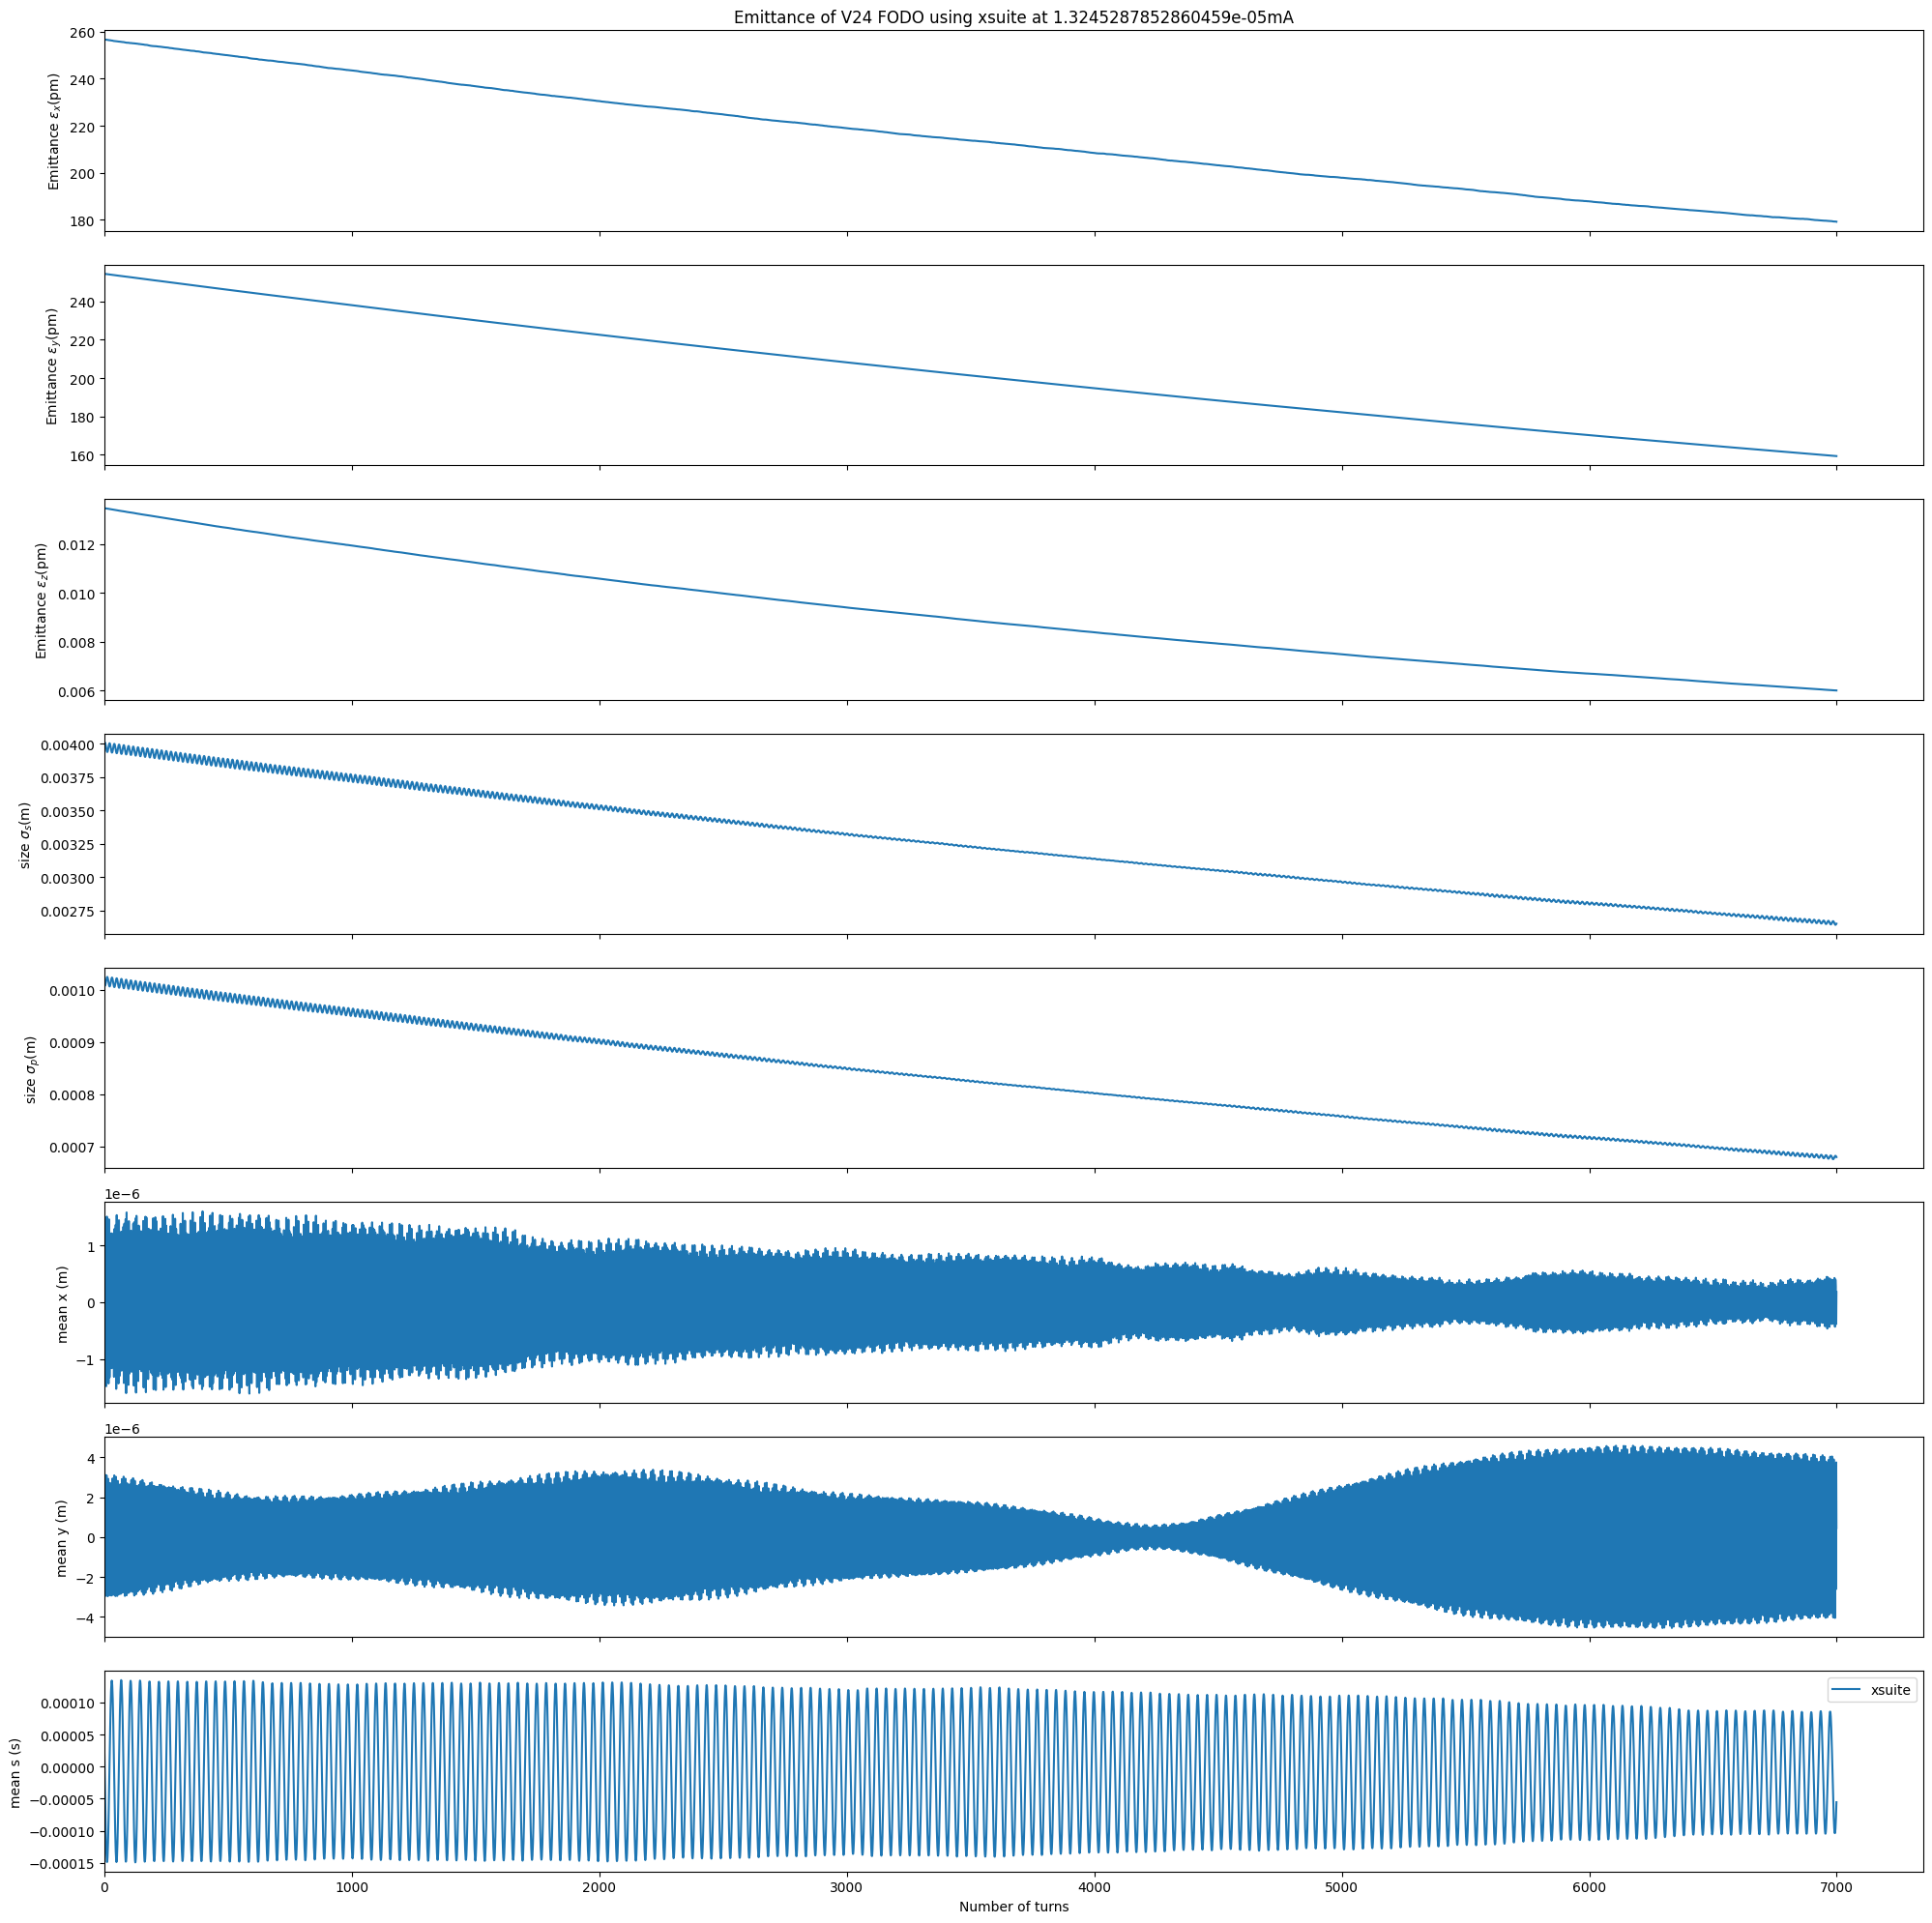

In [23]:
fig, axes = plt.subplots(8, 1, figsize=(20, 20), sharex=True)

x = np.arange(n_turns)

axes[0].plot(emit_x*1e12, label="xsuite")
axes[0].set_ylabel(r"Emittance $\epsilon_{x}$(pm)")
axes[0].set_title(f"Emittance of V24 FODO using xsuite at {D_Q/D_t}mA")

axes[1].plot(emit_y*1e12, label="xsuite")
axes[1].set_ylabel(r"Emittance $\epsilon_{y}$(pm)")

axes[2].plot(emit_z*1e12, label="xsuite")
axes[2].set_ylabel(r"Emittance $\epsilon_{z}$(pm)")

axes[3].plot(sig_z, label="xsuite")
axes[3].set_ylabel(r"size $\sigma_{s}$(m)")


axes[4].plot(sig_p, label="xsuite")
axes[4].set_ylabel(r"size $\sigma_{p}$(m)")


axes[5].plot(mean_x, label="xsuite")
axes[5].set_ylabel(r"mean x (m)")

axes[6].plot(mean_y, label="xsuite")
axes[6].set_ylabel(r"mean y (m)")


axes[7].plot(mean_z, label="xsuite")
axes[7].set_ylabel(r"mean s (s)")
axes[7].set_xlabel("Number of turns")
plt.xlim(0,)
plt.tight_layout()

plt.legend()
plt.show()

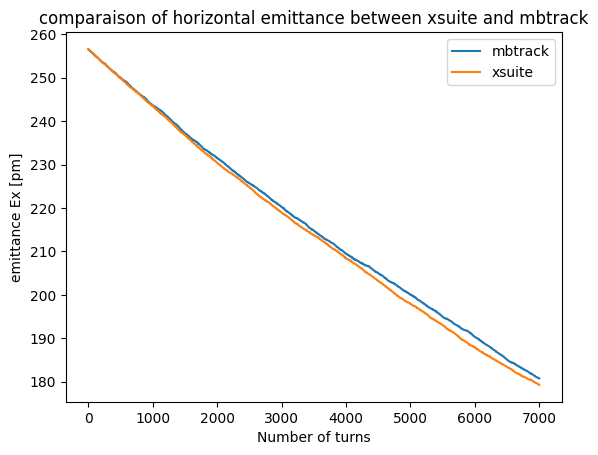

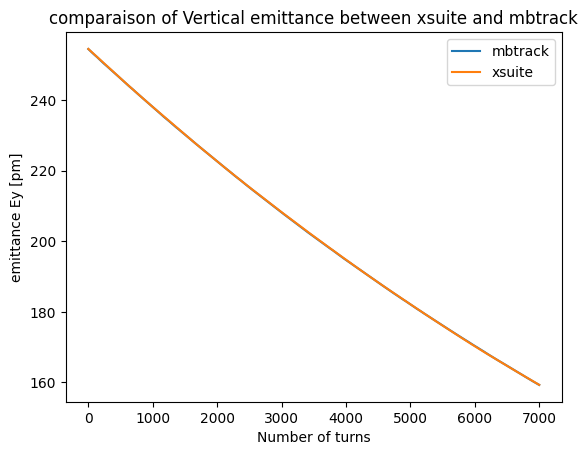

last mbtrck emitx(pm):  180.7568508610342
last xsuite emitx(pm):  179.25145657508972
parameter equilibrium emit(pm):  0.00042904176446316303
parameter equilibrium emitx(pm):  16.792275775376197


In [30]:
#############################################   hdf5 cell  ###################################
%matplotlib inline
file_ = "_outputs/CIMP_jupyter_250602_150955_dx_min_matched_test_xbunch.hdf5"
with h5py.File(file_, 'r') as f: # data file
    # print("Keys: %s" % f.keys())
    group = f["BunchData_1"]
    emit = group["emit"][:]
    current = f["BunchData_1"]["current"][0]
    emit = np.array(emit)
    mean = np.array(f["BunchData_1"]["mean"][:])
    std = np.array(f["BunchData_1"]["std"][:])

plt.plot(emit[0,:]*1e12,label="mbtrack")
plt.plot(emit_x*1e12, label="xsuite")
plt.xlabel("Number of turns")
plt.ylabel("emittance Ex [pm]")
plt.title("comparaison of horizontal emittance between xsuite and mbtrack")
# plt.xlim(0,10000)
plt.legend()
# plt.savefig("comparaison EX mbtrack using pshiS.png", dpi=300)
plt.show()
plt.plot(emit[1,:]*1e12,label="mbtrack")
plt.plot(emit_y*1e12, label="xsuite")
plt.xlabel("Number of turns")
plt.ylabel("emittance Ey [pm]")
plt.title("comparaison of Vertical emittance between xsuite and mbtrack")
plt.legend()
# plt.savefig("comparaison EY mbtrack using pshiS.png", dpi=300)
plt.show()
print("last mbtrck emitx(pm): ",emit[0,-1]*1e12)
print("last xsuite emitx(pm): ",emit_x[-1]*1e12)
print("parameter equilibrium emit(pm): ",beam_param.emit_eq*1e12/beam_param.gamma)
print("parameter equilibrium emitx(pm): ",beam_param.epsnx_eq*1e12/beam_param.gamma)

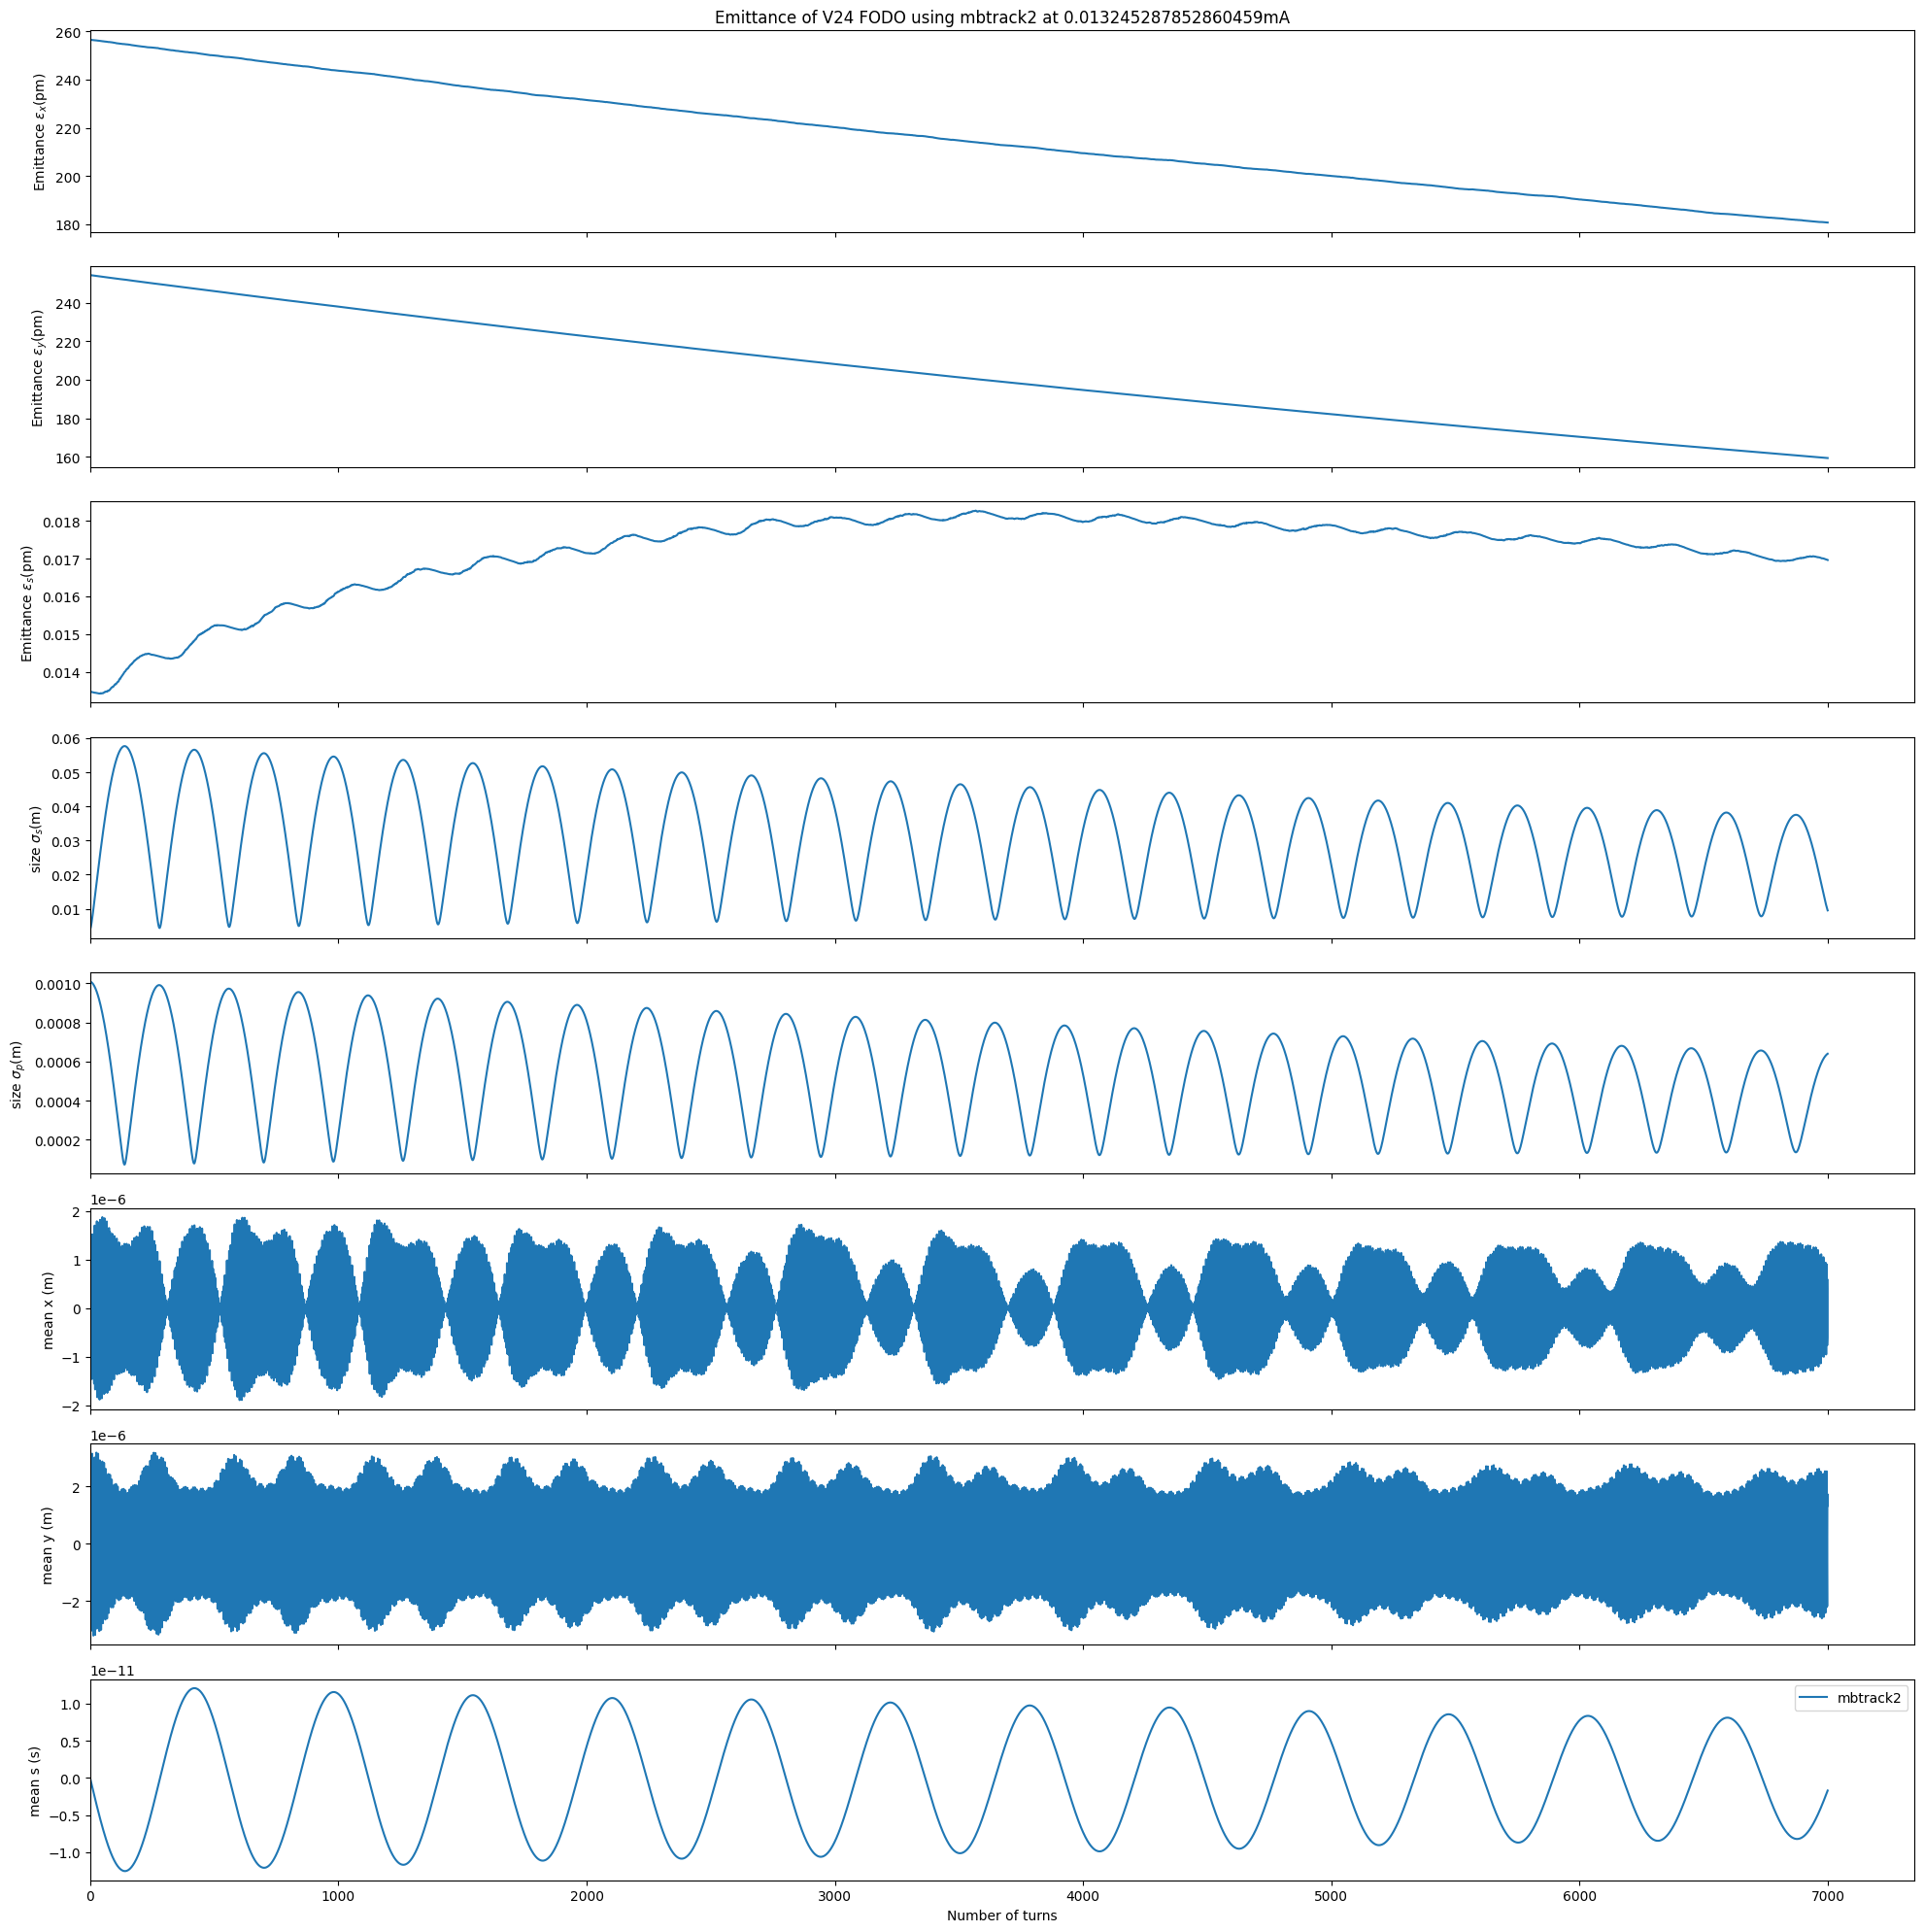

In [32]:
# plt.cla()
fig, axes = plt.subplots(8, 1, figsize=(20, 20), sharex=True)

axes[0].plot(emit[0,:]*1e12, label="mbtrack2")
axes[0].set_ylabel(r"Emittance $\epsilon_{x}$(pm)")
axes[0].set_title(f"Emittance of V24 FODO using mbtrack2 at {current*1e3}mA")

axes[1].plot(emit[1,:]*1e12, label="mbtrack2")
axes[1].set_ylabel(r"Emittance $\epsilon_{y}$(pm)")


axes[2].plot(emit[2,:]*1e12, label="mbtrack2")
axes[2].set_ylabel(r"Emittance $\epsilon_{s}$(pm)")


axes[3].plot(std[4,:]*cons.c, label="mbtrack2")
axes[3].set_ylabel(r"size $\sigma_{s}$(m)")


axes[4].plot(std[5,:], label="mbtrack2")
axes[4].set_ylabel(r"size $\sigma_{p}$(m)")


axes[5].plot(mean[0,:], label="mbtrack2")
axes[5].set_ylabel(r"mean x (m)")

axes[6].plot(mean[2,:], label="mbtrack2")
axes[6].set_ylabel(r"mean y (m)")


axes[7].plot(mean[4,:], label="mbtrack2")
axes[7].set_ylabel(r"mean s (s)")
axes[7].set_xlabel("Number of turns")
plt.xlim(0,)
plt.tight_layout()

plt.legend()
plt.show()

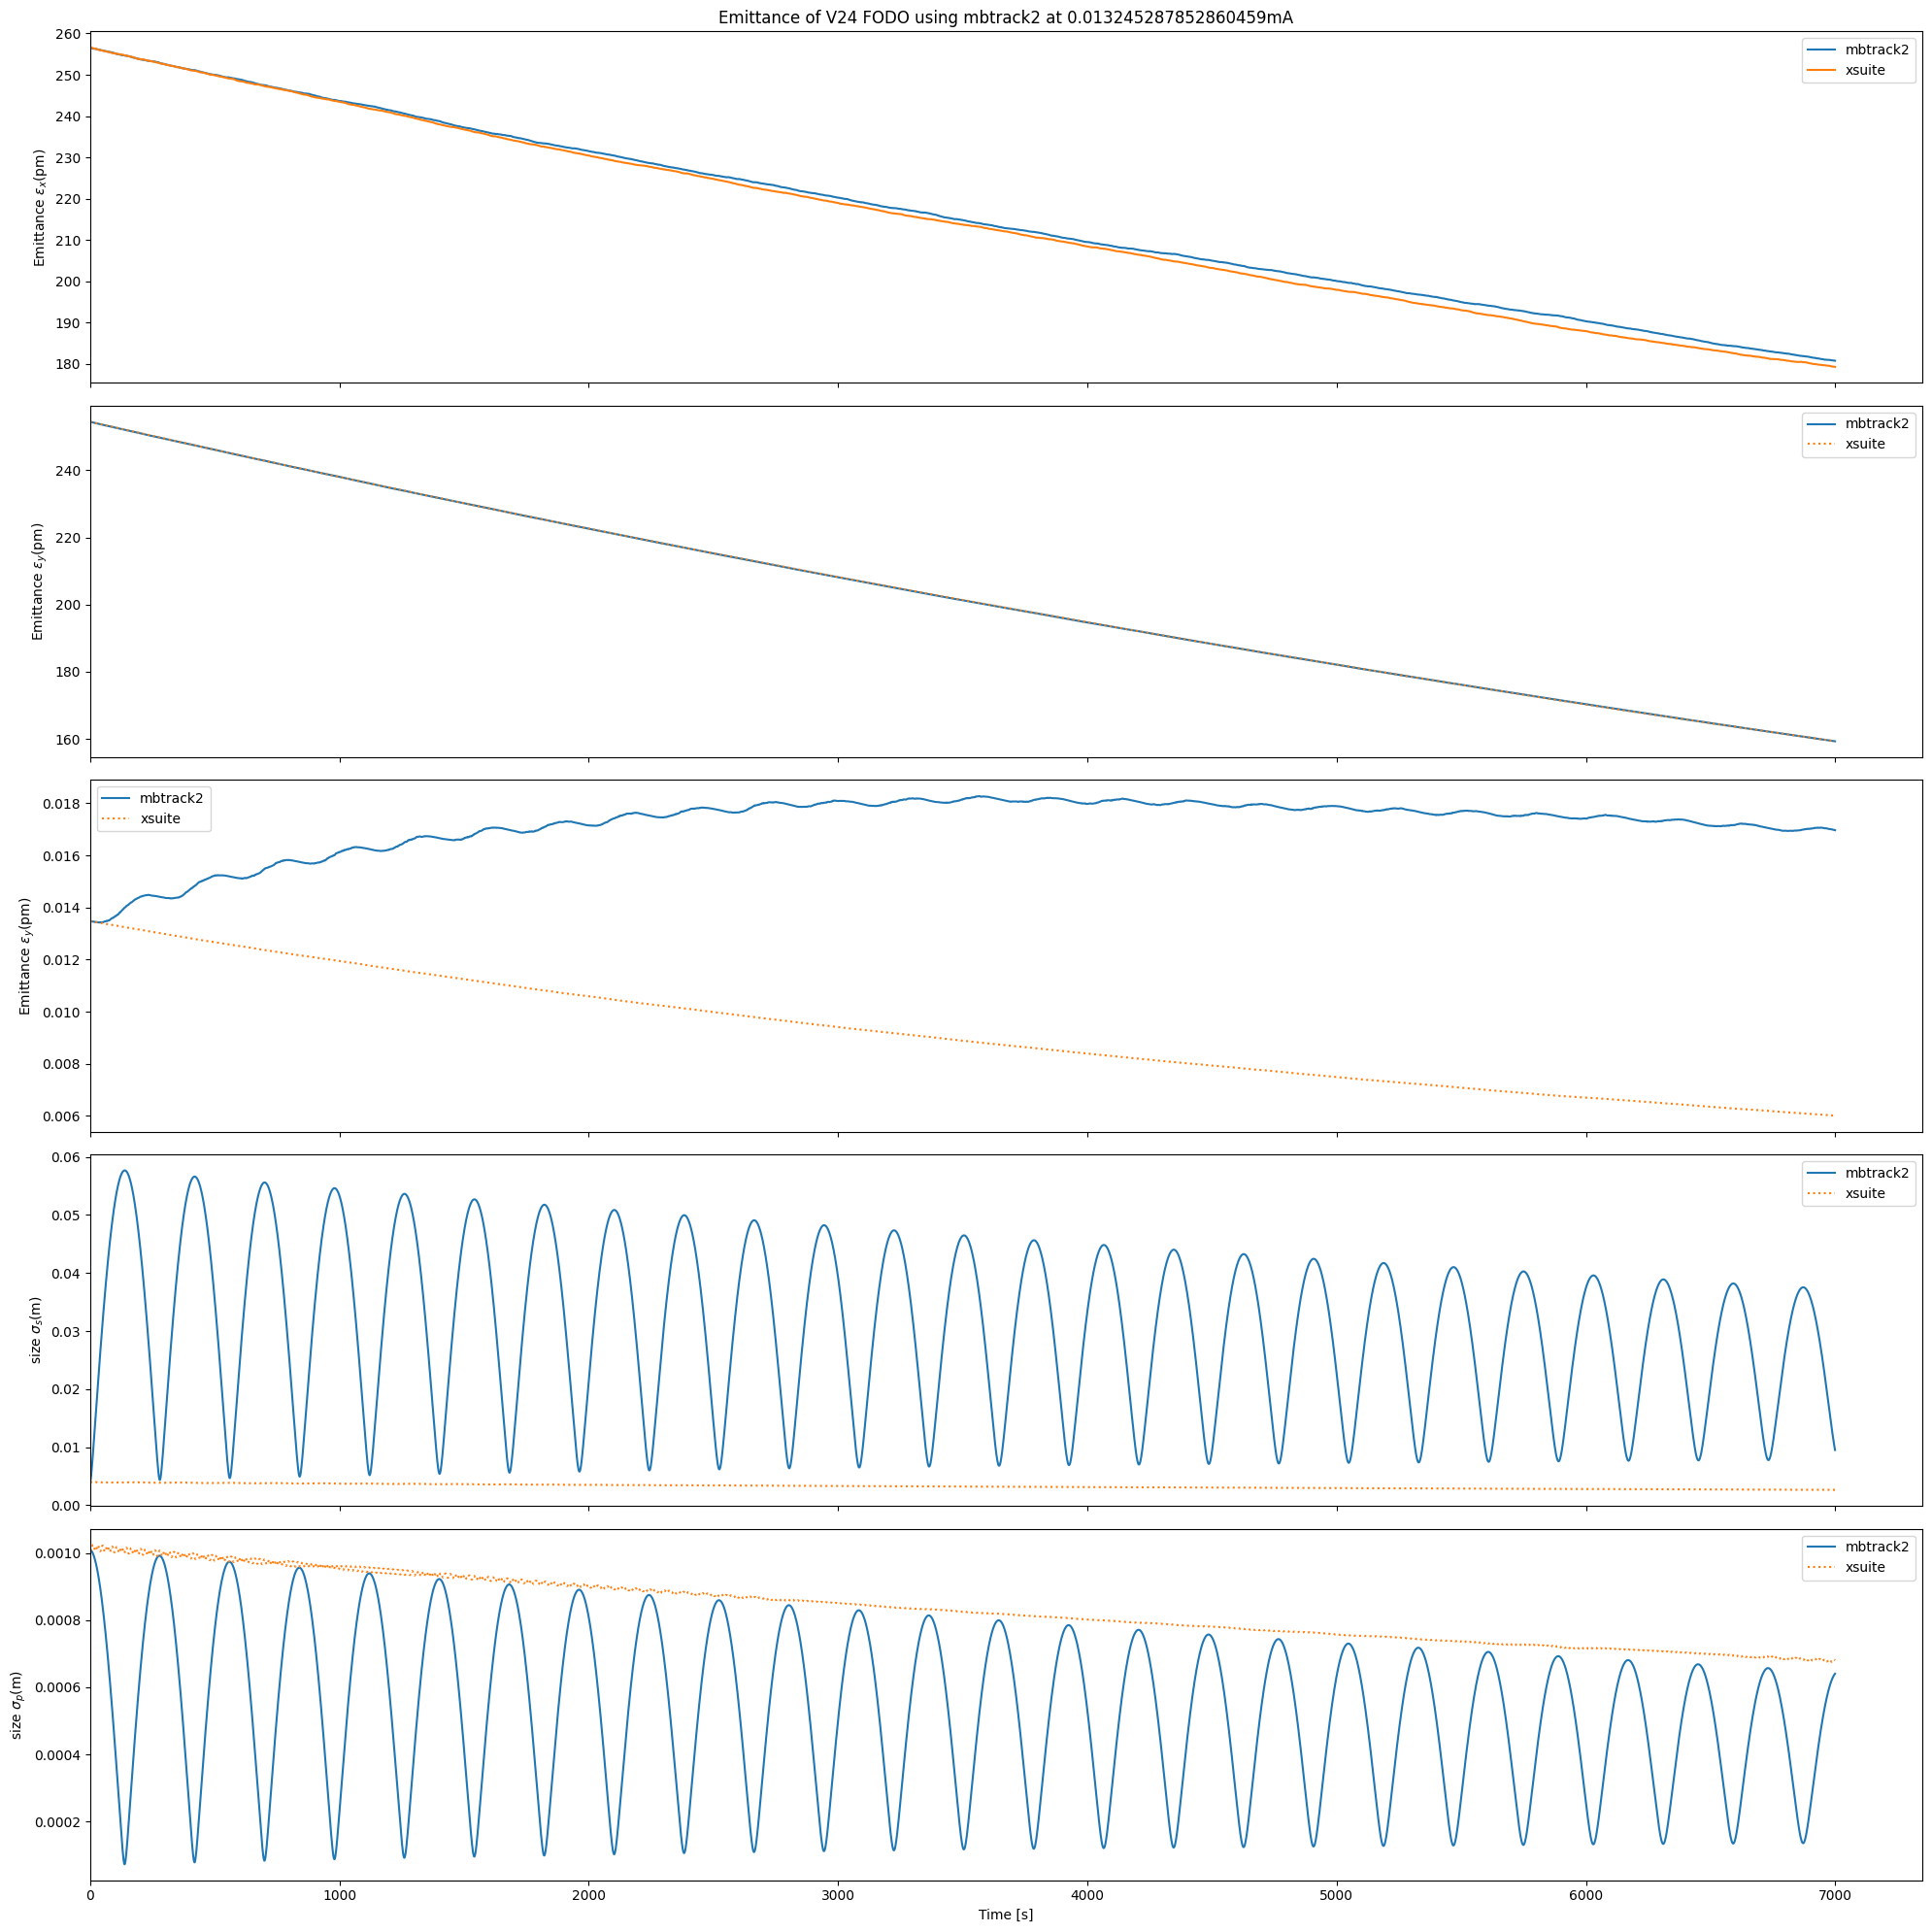

In [27]:
%matplotlib inline
fig, axes = plt.subplots(5, 1, figsize=(20, 20), sharex=True)

axes[0].plot(emit[0,:]*1e12, label="mbtrack2")
axes[0].plot(emit_x*1e12, label="xsuite")
axes[0].set_ylabel(r"Emittance $\epsilon_{x}$(pm)")
axes[0].set_title(f"Emittance of V24 FODO using mbtrack2 at {current*1e3}mA")

axes[1].plot(emit[1,:]*1e12, label="mbtrack2")
axes[1].plot(emit_y*1e12, label="xsuite", ls="dotted")
axes[1].set_ylabel(r"Emittance $\epsilon_{y}$(pm)")

axes[2].plot(emit[2,:]*1e12, label="mbtrack2")
axes[2].plot(emit_z*1e12, label="xsuite", ls="dotted")
axes[2].set_ylabel(r"Emittance $\epsilon_{y}$(pm)")

axes[3].plot(std[4,:]*cons.c, label="mbtrack2")
axes[3].plot(sig_z, label="xsuite", ls="dotted")
axes[3].set_ylabel(r"size $\sigma_{s}$(m)")

axes[4].plot(std[5,:], label="mbtrack2")
axes[4].plot(sig_p, label="xsuite", ls="dotted")
axes[4].set_ylabel(r"size $\sigma_{p}$(m)")



axes[4].set_xlabel("Time [s]")
plt.xlim(0,)
plt.tight_layout()
for ax in axes:
    ax.legend()

plt.savefig("noibs deletethis.png",dpi=300)
plt.show()